In [1]:
# import libraries

from functions import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sqlite3
import os
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# investigate data
os.getcwd()
cwd = "C:\\Users\\Gustavo\\flatiron\\class-material\\section02\\week06\\dsc-case-study-hypothesis-testing\\"

In [3]:
conn = sqlite3.Connection(f"{cwd}data\\Northwind.sqlite")
cur = conn.cursor()

OperationalError: unable to open database file

In [16]:
get_table_names(conn)

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

In [17]:
wanted_tables = ['Product','OrderDetail','Category']
for table in wanted_tables:
    print(table, get_table_column_names(conn, table), '\n')

Product ['Id', 'ProductName', 'SupplierId', 'CategoryId', 'QuantityPerUnit', 'UnitPrice', 'UnitsInStock', 'UnitsOnOrder', 'ReorderLevel', 'Discontinued'] 

OrderDetail ['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount'] 

Category ['Id', 'CategoryName', 'Description'] 



In [18]:
for table in wanted_tables:
    display_table_head(conn, table)

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.0,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.0,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.0,53,0,0,0


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0


,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses


In [19]:
OrderDetail_df = load_table_as_df(conn, 'OrderDetail')

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [20]:
OrderDetail_df['Discount'].unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

In [23]:
special_case = OrderDetail_df[OrderDetail_df['OrderId'] == 11077].copy()

In [24]:
OrderDetail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [27]:
# Discard too low percentages
for discount in OrderDetail_df['Discount'].unique():
    if len(OrderDetail_df[OrderDetail_df['Discount'] == discount]) < 5:
        OrderDetail_df = OrderDetail_df[OrderDetail_df['Discount'] != discount]
    else:
        print(len(OrderDetail_df[OrderDetail_df['Discount'] == discount]))

1317
157
185
161
154
173


In [28]:
OrderDetail_df['Discount'].unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 ])

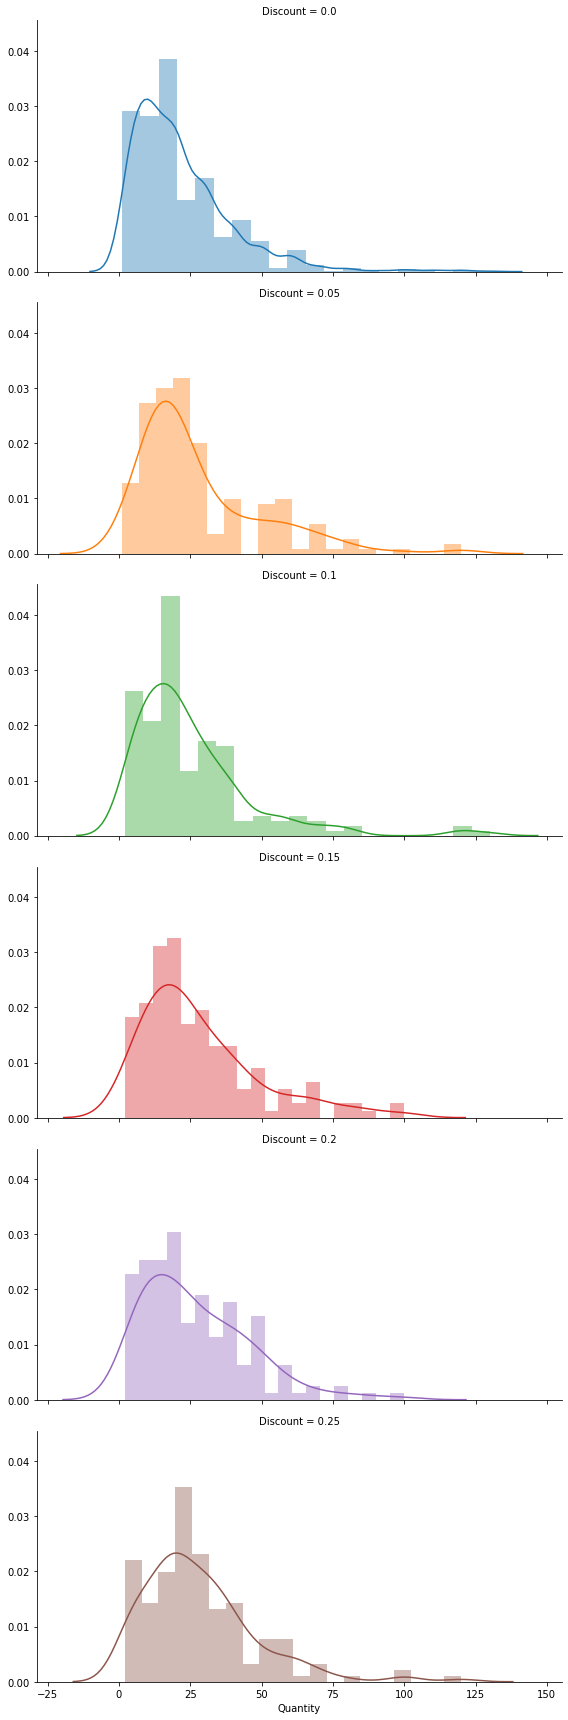

In [29]:
# Show the distributions of each of the discount rates
g = sns.FacetGrid(OrderDetail_df, row="Discount", hue='Discount', sharex=True, height=4, aspect=2)
g.map(sns.distplot, "Quantity", bins=20)
plt.show()

# Question 1: Is there a difference in quantity of products sold by discount rate? 

In [30]:
# view mean and std for each discount
mean_and_stds_discounts = {}
for discount in OrderDetail_df['Discount'].unique():
    mean_and_stds_discounts[f"Discount={discount}"] = OrderDetail_df[OrderDetail_df['Discount'] == discount]['Quantity'].agg(['mean','std'])
display(mean_and_stds_discounts)


{'Discount=0.0': mean    21.715262
 std     17.507493
 Name: Quantity, dtype: float64,
 'Discount=0.15': mean    28.382166
 std     20.923099
 Name: Quantity, dtype: float64,
 'Discount=0.05': mean    28.010811
 std     22.187685
 Name: Quantity, dtype: float64,
 'Discount=0.2': mean    27.024845
 std     18.832801
 Name: Quantity, dtype: float64,
 'Discount=0.25': mean    28.24026
 std     20.12057
 Name: Quantity, dtype: float64,
 'Discount=0.1': mean    25.236994
 std     21.186503
 Name: Quantity, dtype: float64}

In [31]:
OrderDetail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2147 entries, 0 to 2154
Data columns (total 6 columns):
Id           2147 non-null object
OrderId      2147 non-null int64
ProductId    2147 non-null int64
UnitPrice    2147 non-null float64
Quantity     2147 non-null int64
Discount     2147 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 117.4+ KB


## ANOVA and Tukey Tests
H0: Quanity sold is the same across all discount rates

HA: Discount rate causes a differnce in quantity of products sold

In [32]:
# perform test
formula = 'Quantity ~ C(Discount)'
anova_test(formula, OrderDetail_df)


,sum_sq,df,F,PR(>F)
C(Discount),17348.854662,5.0,9.798709,2.840681e-09
Residual,758138.565924,2141.0,NaN,NaN


### PR suggests that there is a strong correlation and we can thus reject our null hypothesis. Lets see between the biggest two

In [33]:
OrderDetail_df.head()
reps_comp = pairwise_tukeyhsd(endog=OrderDetail_df['Quantity'], groups=OrderDetail_df['Discount'], alpha=0.05)
print(reps_comp)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0   0.05   6.2955  0.001  2.0814 10.5097   True
   0.0    0.1   3.5217 0.1885 -0.8187  7.8622  False
   0.0   0.15   6.6669  0.001  2.1352 11.1986   True
   0.0    0.2   5.3096 0.0096  0.8285  9.7907   True
   0.0   0.25    6.525  0.001   1.954  11.096   True
  0.05    0.1  -2.7738  0.704 -8.4504  2.9028  False
  0.05   0.15   0.3714    0.9 -5.4528  6.1955  False
  0.05    0.2   -0.986    0.9 -6.7708  4.7989  False
  0.05   0.25   0.2294    0.9 -5.6253  6.0842  False
   0.1   0.15   3.1452 0.6333  -2.771  9.0613  False
   0.1    0.2   1.7879    0.9 -4.0896  7.6653  False
   0.1   0.25   3.0033  0.677  -2.943  8.9496  False
  0.15    0.2  -1.3573    0.9 -7.3775  4.6628  False
  0.15   0.25  -0.1419    0.9 -6.2292  5.9454  False
   0.2   0.25   1.2154    0.9 -4.8343  7.2652  False
----------------------------------------------

## Conclusion

# We Reject the Null Hypothesis

## EffectSize/PowerAnalysis/Tukey Testing (if needed)

In [ ]:
# Power Analysis

# Question 2: Is there a difference in number of orders and territory? 

In [2]:
# obtain necessary data

## {Put test name here}
H0: 

HA:

In [4]:
# perform test

## Conclusion

# Question 3: {You decide}

# Question 1: Is there a difference in quantity of products sold by discount rate? 

In [2]:
# obtain necessary data

## {Put test name here}
H0: 

HA:

In [4]:
# perform test

## Conclusion

## EffectSize/PowerAnalysis/Tukey Testing (if needed)

# Question 2: Is there a difference in number of orders and territory? 

In [2]:
# obtain necessary data

## {Put test name here}
H0: 

HA:

In [4]:
# perform test

## Conclusion

In [41]:
OrderDetail_df[OrderDetail_df['OrderId'] == 11077]

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2130,11077/2,11077,2,19.00,24,0.20
2131,11077/3,11077,3,10.00,4,0.00
2132,11077/4,11077,4,22.00,1,0.00
2133,11077/6,11077,6,25.00,1,0.02
2134,11077/7,11077,7,30.00,1,0.05
2135,11077/8,11077,8,40.00,2,0.10
2136,11077/10,11077,10,31.00,1,0.00
2137,11077/12,11077,12,38.00,2,0.05
2138,11077/13,11077,13,6.00,4,0.00
2139,11077/14,11077,14,23.25,1,0.03
